# פטר והזאב: מבוא ללמידת חיזוק

במדריך זה נלמד כיצד ליישם למידת חיזוק לבעיה של מציאת מסלול. ההקשר שאוב מהאגדה המוזיקלית [פטר והזאב](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) מאת המלחין הרוסי [סרגיי פרוקופייב](https://en.wikipedia.org/wiki/Sergei_Prokofiev). זהו סיפור על החלוץ הצעיר פטר, שיוצא באומץ מביתו אל קרחת היער כדי לרדוף אחרי הזאב. אנו נאמן אלגוריתמים של למידת מכונה שיעזרו לפטר לחקור את האזור שמסביב ולבנות מפה אופטימלית לניווט.

ראשית, נייבא כמה ספריות שימושיות:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## סקירה כללית של למידת חיזוק

**למידת חיזוק** (RL) היא טכניקת למידה שמאפשרת לנו ללמוד התנהגות אופטימלית של **סוכן** בתוך **סביבה** מסוימת על ידי ביצוע ניסויים רבים. סוכן בסביבה זו צריך שיהיה לו **מטרה**, שמוגדרת על ידי **פונקציית תגמול**.

## הסביבה

לשם פשטות, נניח שהעולם של פיטר הוא לוח מרובע בגודל `width` x `height`. כל תא בלוח הזה יכול להיות:
* **קרקע**, שעליה פיטר ויצורים אחרים יכולים ללכת
* **מים**, שעליהם כמובן אי אפשר ללכת
* **עץ** או **דשא** - מקום שבו אפשר לנוח קצת
* **תפוח**, שמייצג משהו שפיטר ישמח למצוא כדי להאכיל את עצמו
* **זאב**, שהוא מסוכן ויש להימנע ממנו

כדי לעבוד עם הסביבה, נגדיר מחלקה בשם `Board`. כדי לא להעמיס יותר מדי על המחברת הזו, העברנו את כל הקוד שעוסק בעבודה עם הלוח למודול נפרד בשם `rlboard`, אותו נייבא עכשיו. תוכלו להציץ בתוך המודול הזה כדי לקבל פרטים נוספים על המימוש הפנימי.


In [2]:
from rlboard import *

בואו עכשיו ניצור לוח אקראי ונראה איך הוא נראה:


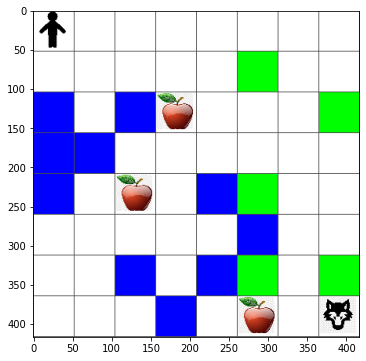

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## פעולות ומדיניות

בדוגמה שלנו, המטרה של פיטר תהיה למצוא תפוח, תוך הימנעות מהזאב ומכשולים אחרים. כדי לעשות זאת, הוא יכול למעשה להסתובב עד שימצא תפוח. לכן, בכל מיקום הוא יכול לבחור בין אחת מהפעולות הבאות: למעלה, למטה, שמאלה וימינה. נגדיר את הפעולות הללו כמשתנה מסוג מילון, ונמפה אותן לזוגות של שינויים מתאימים בקואורדינטות. לדוגמה, תנועה ימינה (`R`) תתאים לזוג `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

האסטרטגיה של הסוכן שלנו (פיטר) מוגדרת על ידי מה שנקרא **מדיניות**. בואו נבחן את המדיניות הפשוטה ביותר שנקראת **הליכה אקראית**.

## הליכה אקראית

בואו נפתור את הבעיה שלנו תחילה על ידי יישום אסטרטגיית הליכה אקראית.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

בואו נריץ ניסוי הליכה אקראית מספר פעמים ונראה את מספר הצעדים הממוצע שנלקחו:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## פונקציית תגמול

כדי להפוך את המדיניות שלנו לחכמה יותר, עלינו להבין אילו מהלכים הם "טובים" יותר מאחרים.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

בנו טבלת Q, או מערך רב-ממדי. מכיוון שללוח שלנו יש ממדים `width` x `height`, ניתן לייצג את טבלת ה-Q באמצעות מערך numpy עם צורה של `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

העבר את טבלת Q לפונקציית העלילה כדי להמחיש את הטבלה על הלוח:


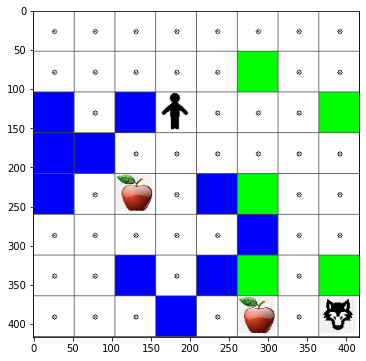

In [9]:
m.plot(Q)

## מהות Q-Learning: משוואת בלמן ואלגוריתם הלמידה

כתבו פסאודו-קוד עבור אלגוריתם הלמידה שלנו:

* אתחלו את טבלת Q עם מספרים שווים לכל המצבים והפעולות
* קבעו את קצב הלמידה $\alpha\leftarrow 1$
* חזרו על הסימולציה פעמים רבות
   1. התחילו במיקום אקראי
   1. חזרו
        1. בחרו פעולה $a$ במצב $s$
        2. בצעו את הפעולה על ידי מעבר למצב חדש $s'$
        3. אם נתקלנו בתנאי סיום המשחק, או שהתגמול הכולל קטן מדי - צאו מהסימולציה  
        4. חשבו את התגמול $r$ במצב החדש
        5. עדכנו את פונקציית Q לפי משוואת בלמן: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. עדכנו את התגמול הכולל והקטינו את $\alpha$.

## ניצול מול חקירה

הגישה הטובה ביותר היא לאזן בין חקירה לניצול. ככל שנלמד יותר על הסביבה שלנו, נהיה נוטים יותר לעקוב אחר המסלול האופטימלי, אך עדיין כדאי לבחור מדי פעם את הדרך הלא מוכרת.

## מימוש ב-Python

עכשיו אנחנו מוכנים לממש את אלגוריתם הלמידה. לפני כן, אנחנו גם צריכים פונקציה שתמיר מספרים שרירותיים בטבלת Q לווקטור של הסתברויות עבור הפעולות המתאימות:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

אנו מוסיפים כמות קטנה של `eps` לווקטור המקורי כדי להימנע מחלוקה באפס במקרה ההתחלתי, כאשר כל הרכיבים של הווקטור זהים.

אלגוריתם הלמידה בפועל שנריץ עבור 5000 ניסויים, הנקראים גם **epochs**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

לאחר ביצוע האלגוריתם הזה, טבלת ה-Q צריכה להתעדכן עם ערכים שמגדירים את האטרקטיביות של פעולות שונות בכל שלב. הצג את הטבלה כאן:


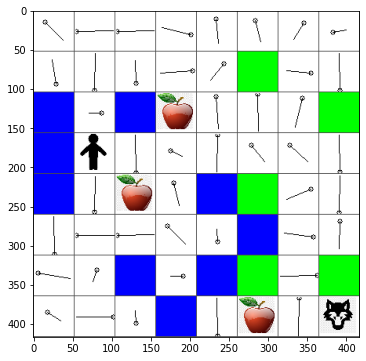

In [12]:
m.plot(Q)

## בדיקת המדיניות

מכיוון ש-Q-Table מציג את "האטרקטיביות" של כל פעולה בכל מצב, קל מאוד להשתמש בו כדי להגדיר את הניווט היעיל בעולם שלנו. במקרה הפשוט ביותר, ניתן פשוט לבחור את הפעולה שמתאימה לערך הגבוה ביותר ב-Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

אם תנסו את הקוד למעלה מספר פעמים, ייתכן שתבחינו שלפעמים הוא פשוט "נתקע", ויש צורך ללחוץ על כפתור ה-STOP במחברת כדי להפסיק אותו.

> **משימה 1:** ערכו את הפונקציה `walk` כך שתוגבל לאורך מקסימלי של מסלול לפי מספר צעדים מסוים (לדוגמה, 100), וצפו כיצד הקוד למעלה מחזיר את הערך הזה מדי פעם.

> **משימה 2:** ערכו את הפונקציה `walk` כך שלא תחזור למקומות שבהם כבר הייתה בעבר. זה ימנע מהפונקציה `walk` להיכנס ללולאה, אך עדיין ייתכן שהסוכן ימצא את עצמו "לכוד" במקום שממנו אינו יכול להימלט.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


## חקירת תהליך הלמידה


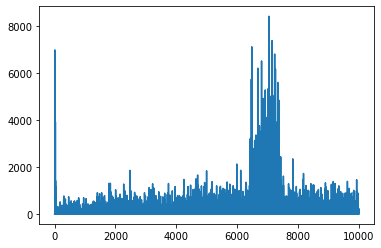

In [15]:
plt.plot(lpath)

מה שאנחנו רואים כאן הוא שבתחילה אורך המסלול הממוצע עלה. זה כנראה נובע מהעובדה שכאשר אין לנו ידע על הסביבה - יש סיכוי גבוה שנתקע במצבים גרועים, כמו מים או זאב. ככל שאנחנו לומדים יותר ומתחילים להשתמש בידע הזה, אנחנו יכולים לחקור את הסביבה למשך זמן ארוך יותר, אבל עדיין לא יודעים היטב היכן נמצאות התפוחים.

ברגע שאנחנו לומדים מספיק, זה נהיה קל יותר לסוכן להשיג את המטרה, ואורך המסלול מתחיל לרדת. עם זאת, אנחנו עדיין פתוחים לחקירה, ולכן לעיתים קרובות אנחנו סוטים מהמסלול הטוב ביותר ובוחנים אפשרויות חדשות, מה שגורם למסלול להיות ארוך יותר מהאופטימלי.

מה שאנחנו גם מבחינים בגרף הזה הוא שבשלב מסוים האורך עלה בפתאומיות. זה מצביע על האופי הסטוכסטי של התהליך, ועל כך שבשלב מסוים אנחנו יכולים "לקלקל" את מקדמי ה-Q-Table על ידי החלפתם בערכים חדשים. באופן אידיאלי, יש למזער זאת על ידי הקטנת קצב הלמידה (כלומר, לקראת סוף האימון אנחנו משנים את ערכי ה-Q-Table רק במידה קטנה).

בסך הכול, חשוב לזכור שההצלחה והאיכות של תהליך הלמידה תלויות באופן משמעותי בפרמטרים, כמו קצב הלמידה, דעיכת קצב הלמידה ופקטור ההנחה. פרמטרים אלו נקראים לעיתים קרובות **היפר-פרמטרים**, כדי להבדילם מ-**פרמטרים** שאותם אנחנו מאמנים במהלך האימון (למשל, מקדמי ה-Q-Table). התהליך של מציאת הערכים הטובים ביותר להיפר-פרמטרים נקרא **אופטימיזציית היפר-פרמטרים**, והוא נושא שראוי לדיון נפרד.


## תרגיל
#### עולם מציאותי יותר של פיטר והזאב

במצב שלנו, פיטר הצליח לנוע כמעט בלי להתעייף או להרגיש רעב. בעולם מציאותי יותר, הוא צריך לשבת ולנוח מדי פעם, וגם להאכיל את עצמו. בואו נעשה את העולם שלנו מציאותי יותר על ידי יישום הכללים הבאים:

1. כאשר פיטר עובר ממקום למקום, הוא מאבד **אנרגיה** וצובר **עייפות**.
2. פיטר יכול להחזיר לעצמו אנרגיה על ידי אכילת תפוחים.
3. פיטר יכול להיפטר מעייפות על ידי מנוחה מתחת לעץ או על הדשא (כלומר, הליכה למיקום בלוח שבו יש עץ או דשא - שדה ירוק).
4. פיטר צריך למצוא ולהרוג את הזאב.
5. כדי להרוג את הזאב, פיטר צריך להגיע לרמות מסוימות של אנרגיה ועייפות, אחרת הוא מפסיד בקרב.

שנו את פונקציית התגמול בהתאם לכללי המשחק, הריצו את אלגוריתם הלמידה החיזוקית כדי ללמוד את האסטרטגיה הטובה ביותר לנצח במשחק, והשוו את התוצאות של הליכה אקראית עם האלגוריתם שלכם מבחינת מספר המשחקים שניצחו והפסידו.

> **Note**: ייתכן שתצטרכו להתאים את ההיפרפרמטרים כדי שזה יעבוד, במיוחד את מספר האפוקים. מכיוון שהצלחה במשחק (המאבק עם הזאב) היא אירוע נדיר, אפשר לצפות לזמן אימון ארוך יותר.



---

**כתב ויתור**:  
מסמך זה תורגם באמצעות שירות תרגום מבוסס בינה מלאכותית [Co-op Translator](https://github.com/Azure/co-op-translator). למרות שאנו שואפים לדיוק, יש לקחת בחשבון שתרגומים אוטומטיים עשויים להכיל שגיאות או אי-דיוקים. המסמך המקורי בשפתו המקורית נחשב למקור הסמכותי. למידע קריטי, מומלץ להשתמש בתרגום מקצועי על ידי מתרגם אנושי. איננו נושאים באחריות לכל אי-הבנה או פרשנות שגויה הנובעת משימוש בתרגום זה.
